# Pairs Trading- finding pairs based on Clustering

In this case study, we will use clustering methods to select pairs for a pairs trading
strategy.

# 1. Problem Definition

Our goal in this case study is to perform clustering analysis on the stocks of S&P500
and come up with pairs for a pairs trading strategy. The data of the stocks of S&P 500, obtained using pandas_datareader from yahoo finance. It includes price data from 2018 onwards.

# 2. Getting Started- Loading the data and python packages

In [1]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import datetime
import pandas_datareader as dr

from sklearn import cluster, covariance, manifold
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.cluster import AffinityPropagation, DBSCAN
from sklearn.metrics import adjusted_mutual_info_score

from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import pdist

# Helper Packages and functions
import matplotlib.ticker as ticker
from itertools import cycle

## 2.2. Loading the Data

In [2]:
#The data already obtained from yahoo finance is imported.
dataset = read_csv('./data/SP500Data.csv',index_col=0)

In [3]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

<a id='2'></a>
# 3. Exploratory Data Analysis

<a id='2.1'></a>
## 3.1. Descriptive Statistics

In [4]:
# Basic info about number of column and rows 
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 448 entries, 2018-01-02 to 2019-10-11
Columns: 502 entries, ABT to ZTS
dtypes: float64(502)
memory usage: 1.7+ MB


In [6]:
set_option('display.precision', 1)
dataset.describe()

,ABT,ABBV,ABMD,ACN,ATVI,ADBE,AMD,AAP,AES,AMG,...,WLTW,WYNN,XEL,XRX,XLNX,XYL,YUM,ZBH,ZION,ZTS
count,448.0,448.0,448.0,448.0,448.0,448.0,448.0,448.0,448.0,448.0,...,448.0,448.0,448.0,448.0,448.0,448.0,448.0,448.0,448.0,448.0
mean,70.9,88.1,307.3,167.5,59.6,252.3,21.8,147.5,14.5,128.4,...,165.1,139.5,51.7,29.2,90.8,74.5,93.5,120.4,49.2,94.8
std,9.0,13.5,72.0,14.6,13.1,29.0,7.4,21.1,2.3,38.6,...,17.4,29.3,6.7,3.5,21.1,4.9,12.0,9.2,4.8,14.4
min,56.3,63.0,159.3,133.7,40.1,177.7,9.5,103.8,10.1,71.8,...,134.8,92.0,42.1,18.9,62.8,61.4,76.3,97.2,38.5,71.5
25%,62.6,78.7,260.6,157.3,47.0,235.4,15.1,133.3,12.8,94.1,...,151.7,114.1,45.7,27.1,71.7,70.5,83.5,114.0,45.1,84.6
50%,70.0,88.5,301.9,162.9,55.3,254.7,21.9,154.9,14.8,113.4,...,158.8,133.0,49.4,29.1,85.2,75.2,89.9,120.6,49.2,90.1
75%,78.6,96.7,368.1,178.3,71.6,273.0,28.4,163.6,16.4,158.9,...,178.1,164.9,56.7,31.5,109.4,78.4,101.5,125.9,53.2,102.0
max,88.7,123.2,449.8,201.1,83.4,311.3,34.4,184.7,18.4,215.8,...,199.4,201.5,65.8,36.5,139.7,84.4,119.2,142.6,58.5,128.5


In [7]:
# look at data
dataset.head(5)

,ABT,ABBV,ABMD,ACN,ATVI,ADBE,AMD,AAP,AES,AMG,...,WLTW,WYNN,XEL,XRX,XLNX,XYL,YUM,ZBH,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,58.8,98.4,192.5,153.8,64.3,177.7,11.0,106.1,10.9,203.0,...,147.0,164.3,47.8,29.4,67.9,68.1,81.6,124.1,50.7,71.8
2018-01-03,58.9,99.9,195.8,154.6,65.3,181.0,11.6,107.1,10.9,202.1,...,149.7,162.5,47.5,29.3,69.2,68.9,81.5,124.9,50.6,72.1
2018-01-04,58.8,99.4,199.2,156.4,64.7,183.2,12.1,111.0,10.8,198.5,...,151.3,163.4,47.1,29.7,70.5,69.4,82.4,124.7,50.8,72.5
2018-01-05,59.0,101.1,202.3,157.7,66.4,185.3,11.9,112.2,10.9,199.5,...,152.2,164.5,46.8,29.9,74.2,69.2,82.8,126.0,50.9,73.4
2018-01-08,58.8,99.5,207.8,158.9,66.6,185.0,12.3,111.4,10.9,200.5,...,151.4,162.3,47.1,30.3,74.6,69.5,83.0,126.2,50.6,74.2


In [8]:
dataset.columns

Index(['ABT', 'ABBV', 'ABMD', 'ACN', 'ATVI', 'ADBE', 'AMD', 'AAP', 'AES',
       'AMG',
       ...
       'WLTW', 'WYNN', 'XEL', 'XRX', 'XLNX', 'XYL', 'YUM', 'ZBH', 'ZION',
       'ZTS'],
      dtype='object', length=502)

<a id='2.2'></a>
## 3.2. Data Visualization

We will take a detailed look into the visualization post clustering. To be honest, it's hard to visualise 498 stocks.

<a id='3'></a>
## 4. Data Preparation

<a id='3.1'></a>
## 4.1. Data Cleaning
We check for the NAs in the rows, either drop them or fill them with the mean of the column.

In [9]:
#Checking for any null values and removing the null values'''
print('Null Values =',dataset.isnull().values.any())

Null Values = True


Getting rid of the columns with more than 30% missing values. 

In [10]:
missing_fractions = dataset.isnull().mean().sort_values(ascending=False)

drop_list = sorted(list(missing_fractions[missing_fractions > 0.3].index))

dataset.drop(labels=drop_list, axis=1, inplace=True)

In [11]:
drop_list

['CTVA', 'DOW', 'FOX', 'FOXA']

Given that there are null values drop the rown containing the null values.

In [12]:
# Fill the missing values with the last value available in the dataset. 
dataset=dataset.fillna(method='ffill')
dataset.head()

,ABT,ABBV,ABMD,ACN,ATVI,ADBE,AMD,AAP,AES,AMG,...,WLTW,WYNN,XEL,XRX,XLNX,XYL,YUM,ZBH,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,58.8,98.4,192.5,153.8,64.3,177.7,11.0,106.1,10.9,203.0,...,147.0,164.3,47.8,29.4,67.9,68.1,81.6,124.1,50.7,71.8
2018-01-03,58.9,99.9,195.8,154.6,65.3,181.0,11.6,107.1,10.9,202.1,...,149.7,162.5,47.5,29.3,69.2,68.9,81.5,124.9,50.6,72.1
2018-01-04,58.8,99.4,199.2,156.4,64.7,183.2,12.1,111.0,10.8,198.5,...,151.3,163.4,47.1,29.7,70.5,69.4,82.4,124.7,50.8,72.5
2018-01-05,59.0,101.1,202.3,157.7,66.4,185.3,11.9,112.2,10.9,199.5,...,152.2,164.5,46.8,29.9,74.2,69.2,82.8,126.0,50.9,73.4
2018-01-08,58.8,99.5,207.8,158.9,66.6,185.0,12.3,111.4,10.9,200.5,...,151.4,162.3,47.1,30.3,74.6,69.5,83.0,126.2,50.6,74.2


<a id='3.2'></a>
## 4.2. Data Transformation

For the purpose of clustering, we will be using annual
returns and variance as the variables as they are the indicators of the stock performance and its volatility. Let us prepare the return and volatility variables from the
data.

In [13]:
# Calculate average annual percentage return and volatilities 
# over a theoretical one year period

returns = dataset.pct_change().mean() * 252
returns = pd.DataFrame(returns)
returns.columns = ['Returns']
returns['Volatility'] = dataset.pct_change().std() * np.sqrt(252)
data=returns

# format the data as a numpy array to feed into the K-Means algorithm
# data = np.asarray([np.asarray(returns['Returns']),np.asarray(returns['Volatility'])]).T

All the variables should be on the same scale before applying clustering, otherwise a feature with large values will dominate the result. We use StandardScaler in sklearn to standardize the dataset’s features onto unit scale (mean = 0 and variance = 1).

In [14]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(data)
rescaledDataset = pd.DataFrame(scaler.fit_transform(data),columns = data.columns, index = data.index)
# summarize transformed data
rescaledDataset.head(2)
X=rescaledDataset
X.head(2)

,Returns,Volatility
ABT,0.8,-0.7
ABBV,-0.9,0.8


The parameters to clusters are the indices and the variables used in the clustering are the columns. Hence the data is in the right format to be fed to the clustering algorithms

<a id='4'></a>
# 5. Evaluate Algorithms and Models

We will look at the following models:

1. KMeans
2. Hierarchical Clustering (Agglomerative Clustering)
3. Affinity Propagation 

## 5.1. K-Means Clustering


<a id='5.1.1'></a>
### 5.1.1. Finding optimal number of clusters

In this step we look at the following metrices:

1. Sum of square errors (SSE) within clusters
2. Silhouette score.

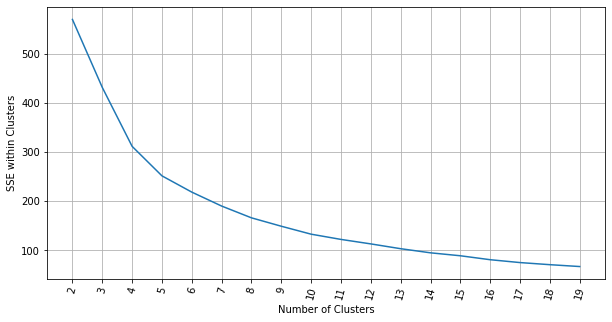

In [15]:
distorsions = []
max_loop=20
for k in range(2, max_loop):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    distorsions.append(kmeans.inertia_)
fig = plt.figure(figsize=(10, 5))
plt.plot(range(2, max_loop), distorsions)
plt.xticks([i for i in range(2, max_loop)], rotation=75)
plt.xlabel("Number of Clusters")
plt.ylabel("SSE within Clusters")
plt.grid(True)

Inspecting the sum of squared errors chart, it appears the elbow “kink” occurs 5 or 6
clusters for this data. Certainly, we can see that as the number of clusters increase pass
6, the sum of square of errors within clusters plateaus off.

#### Silhouette score

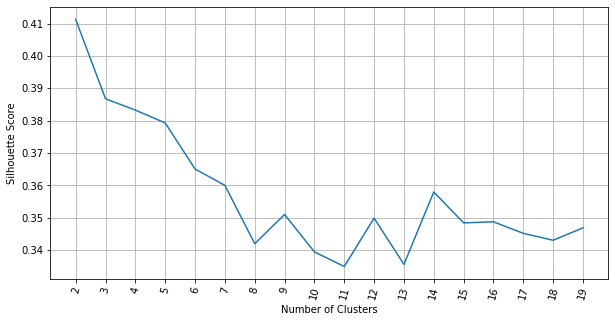

In [16]:
from sklearn import metrics

silhouette_score = []
for k in range(2, max_loop):
        kmeans = KMeans(n_clusters=k,  random_state=10, n_init=10)
        kmeans.fit(X)        
        silhouette_score.append(metrics.silhouette_score(X, kmeans.labels_, random_state=10))
fig = plt.figure(figsize=(10, 5))
plt.plot(range(2, max_loop), silhouette_score)
plt.xticks([i for i in range(2, max_loop)], rotation=75)
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.grid(True)

From the silhouette score chart, we can see that there are various parts of the graph
where a kink can be seen. Since there is not much a difference in SSE after 6 clusters,
we would prefer 6 clusters in the K-means model.

<a id='5.1.2'></a>
### 5.1.2.  Clustering and Visualisation

Let us build the k-means model with six clusters and
visualize the results.

In [17]:
nclust=6

In [18]:
#Fit with k-means
k_means = cluster.KMeans(n_clusters=nclust, algorithm='auto', copy_x=True, 
                         init='k-means++', max_iter=300, n_init=10, 
                         random_state=None, tol=0.0001, verbose=0)
k_means.fit(X)

KMeans(n_clusters=6)

In [19]:
#Extracting labels 
target_labels = k_means.predict(X)

Visualizing how your clusters are formed is no easy task when the number of variables/dimensions in your dataset is very large. One of the methods of visualising a cluster in two-dimensional space.

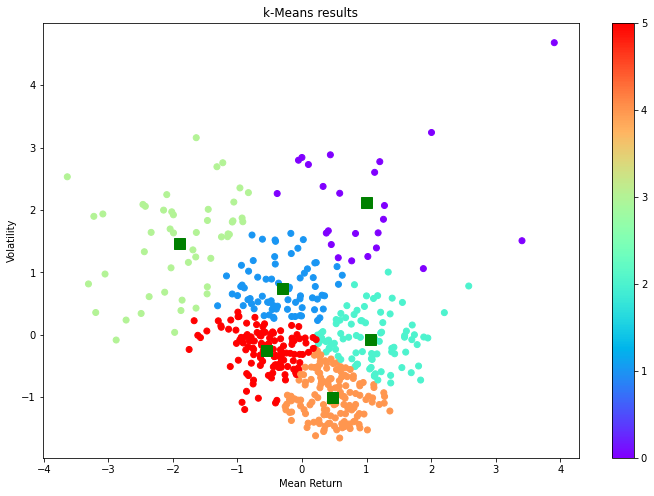

In [20]:
centroids = k_means.cluster_centers_
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0],X.iloc[:,1], c = k_means.labels_, cmap ="rainbow", label = X.index)
ax.set_title('k-Means results')
ax.set_xlabel('Mean Return')
ax.set_ylabel('Volatility')
plt.colorbar(scatter)

plt.plot(centroids[:,0],centroids[:,1],'sg',markersize=11);

Let us check the elements of the clusters

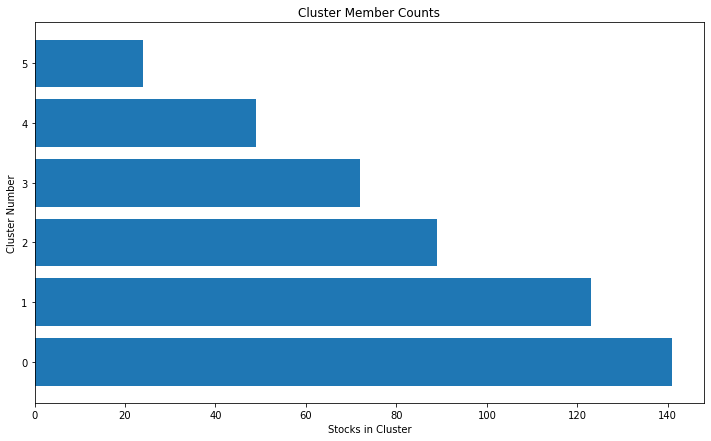

In [21]:
# show number of stocks in each cluster
clustered_series = pd.Series(index=X.index, data=k_means.labels_.flatten())
# clustered stock with its cluster label
clustered_series_all = pd.Series(index=X.index, data=k_means.labels_.flatten())
clustered_series = clustered_series[clustered_series != -1]

plt.figure(figsize=(12,7))
plt.barh(
    range(len(clustered_series.value_counts())), # cluster labels, y axis
    clustered_series.value_counts()
)
plt.title('Cluster Member Counts')
plt.xlabel('Stocks in Cluster')
plt.ylabel('Cluster Number')
plt.show()

The number of stocks in a cluster range from around 40 to 120. Although, the distribution is not equal, we have significant number of stocks in each cluster.

<a id='5.2'></a>
## 5.2. Hierarchical Clustering (Agglomerative Clustering)

In the first step we look at the hierarchy graph and check for the number of clusters

<a id='5.2.1'></a>
### 5.2.1. Building Hierarchy Graph/ Dendogram

The hierarchy class has a dendrogram method which takes the value returned by the linkage method of the same class. The linkage method takes the dataset and the method to minimize distances as parameters. We use 'ward' as the method since it minimizes then variants of distances between the clusters.

In [22]:
from scipy.cluster.hierarchy import dendrogram, linkage, ward
# Calculate linkage
Z= linkage(X, method='ward')
Z[0]

array([3.30000000e+01, 3.14000000e+02, 3.62580431e-03, 2.00000000e+00])

The best way to visualize an agglomerate clustering algorithm is through a dendogram, which displays a cluster tree, the leaves being the individual stocks and the root being the final single cluster. The "distance" between each cluster is shown on the y-axis, and thus the longer the branches are, the less correlated two clusters are.

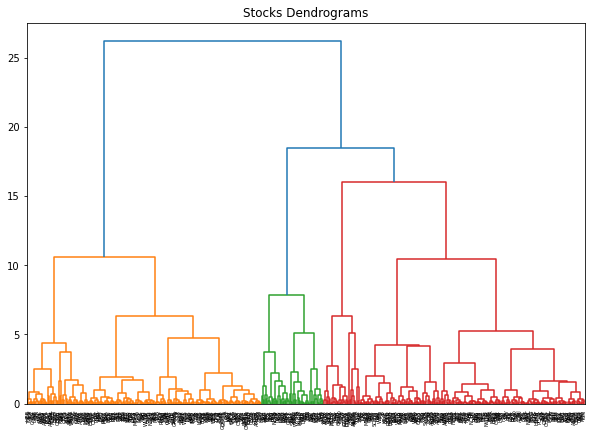

In [23]:
#Plot Dendrogram
plt.figure(figsize=(10, 7))
plt.title("Stocks Dendrograms")
dendrogram(Z,labels = X.index)
plt.show()

Once one big cluster is formed, the longest vertical distance without any horizontal line passing through it is selected and a horizontal line is drawn through it. The number of vertical lines this newly created horizontal line passes is equal to number of clusters.
Then we select the distance threshold to cut the dendrogram to obtain the selected clustering level. The output is the cluster labelled for each row of data. As expected from the dendrogram, a cut at 13 gives us four clusters.

In [24]:
distance_threshold = 13
clusters = fcluster(Z, distance_threshold, criterion='distance')
chosen_clusters = pd.DataFrame(data=clusters, columns=['cluster'])
chosen_clusters['cluster'].unique()

array([1, 4, 3, 2])

<a id='5.2.2'></a>
### 5.2.2.  Clustering and Visualisation

In [25]:
nclust = 4
hc = AgglomerativeClustering(n_clusters=nclust, affinity = 'euclidean', linkage = 'ward')
clust_labels1 = hc.fit_predict(X)

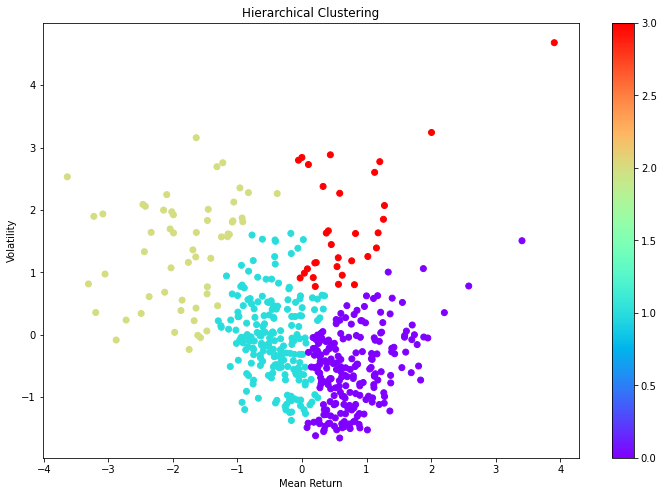

In [26]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0],X.iloc[:,1], c =clust_labels1, cmap ="rainbow")
ax.set_title('Hierarchical Clustering')
ax.set_xlabel('Mean Return')
ax.set_ylabel('Volatility')
plt.colorbar(scatter);

Similar to the plot of k-means clustering, we see that there are some distinct clusters
separated by different colors. 

<a id='5.4'></a>
## 5.4. Cluster Evaluation

If the labels are not known, evaluation must be performed using the model itself. The Silhouette Coefficient (sklearn.metrics.silhouette_score) is an example of such an evaluation, where a higher Silhouette Coefficient score relates to a model with better defined clusters. The Silhouette Coefficient is defined for each sample and is composed of two scores:

In [27]:
from sklearn import metrics
print("km", metrics.silhouette_score(X, k_means.labels_, metric='euclidean'))
print("hc", metrics.silhouette_score(X, hc.fit_predict(X), metric='euclidean'))

km 0.34975288626889356
hc 0.34321495156408627


We now focus on just the k means clustering approach to select the pairs.

<a id='6'></a>
# 6. Pairs Selection

We do not do this.

## Conclusion

The clustering techniques do not directly help in stock trend prediction. However,
they can be effectively used in portfolio construction for finding the right pairs,
which eventually help in risk mitigation and one can achieve superior risk adjusted
returns.

We showed the approaches to finding the appropriate number of clusters in k-means
and built a hierarchy graph in hierarchical clustering. A next step from this case study
would be to explore and backtest various long/short trading strategies with pairs of
stocks from the groupings of stocks.

Clustering can effectively be used for dividing stocks into groups with “similar characteristics” for many other kinds of trading strategies and can help in portfolio construction to ensure we choose a universe of stocks with sufficient diversification
between them.